In [1]:
##### imports

import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, valid_ifthens_with_coverage_correctness_bins, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative,print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if, save_rules_by_if

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [2]:
##### constants
random_seed = 131313

In [3]:
def preprocess_adult(df):
    df = df.drop(columns=["fnlwgt", "education"])
    cols = list(df.columns)
    df[cols] = df[cols].replace([" ?"], np.nan)
    df = df.dropna()
    df["relationship"] = df["relationship"].replace([" Husband", " Wife"], " Married")
    df["income"] = np.where((df["income"] == " <=50K"), 0, 1)
    
    return df

In [4]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = preprocess_adult(X)

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,40,Cuba,0


In [5]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 6.77 s
Wall time: 8.34 s


array([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])

In [7]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10205
           1       0.72      0.61      0.66      3362

    accuracy                           0.85     13567
   macro avg       0.80      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



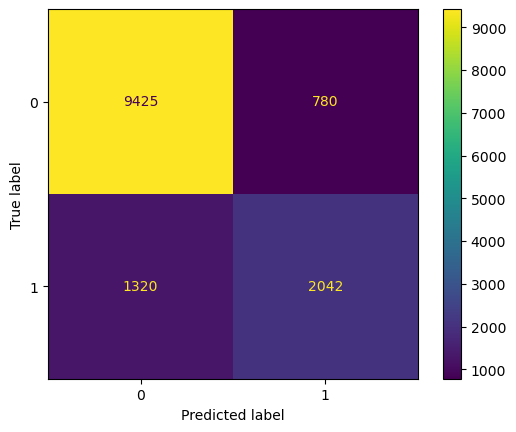

In [8]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Algorithm

In [9]:
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

In [10]:
#Uncomment if you want to find new rules with different support

ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness_bins(
    X_test,
    model=model,
    sensitive_attribute='sex',
    num_features=num_features,
    nbins_affected=10,
    nbins_unaffected=100,
    freqitem_minsupp = 0.05,
    drop_infeasible = True,
    drop_above = False
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.04it/s]

Number of frequent itemsets for affected: {' Female': 3379, ' Male': 3544}
Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████████████████████████████████████████████████████████████████████| 3379/3379 [00:00<00:00, 481846.57it/s]

Number of groups from the intersection: 1742


Number of frequent itemsets for the unaffected: 4477
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|███████████████████████████████████████████████████████████████████████████| 1742/1742 [00:00<00:00, 68498.66it/s]

Computing correctenesses for all valid if-thens.



100%|████████████████████████████████████████████████████████████████████████████████| 812/812 [00:09<00:00, 89.18it/s]

Number of if-thens: 812


In [11]:
list(rules_by_if.items())[0]

(Predicate(features=['capital-gain'], values=[Interval(-0.001, 1593.778, closed='right')]),
 {' Female': (0.9706653947054615,
   [(Predicate(features=['capital-gain'], values=[Interval(7070.636, 8080.727, closed='right')]),
     0.22162162162162158),
    (Predicate(features=['capital-gain'], values=[Interval(14141.273, 15151.364, closed='right')]),
     0.7395577395577395)]),
  ' Male': (0.9713064713064713,
   [(Predicate(features=['capital-gain'], values=[Interval(7070.636, 8080.727, closed='right')]),
     0.5125707102451289),
    (Predicate(features=['capital-gain'], values=[Interval(14141.273, 15151.364, closed='right')]),
     0.8350094280326839)])})

In [12]:
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']
cate_features = ['Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = []

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features

comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain", "capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

In [13]:
from facts.numeric_bins import add_cost_to_rules

In [14]:
rules_by_if_with_costs = add_cost_to_rules(
    rules_by_if,
    X_aff=X_test[preds_Xtest == 0],
    num_features=['age', 'capital-gain', 'capital-loss', 'hours-per-week'],
    sensitive_attribute="sex",
    params=params
)

In [15]:
list(rules_by_if_with_costs.items())[0]

(Predicate(features=['capital-gain'], values=[Interval(-0.001, 1593.778, closed='right')]),
 {' Female': (0.9706653947054615,
   [(Predicate(features=['capital-gain'], values=[Interval(7070.636, 8080.727, closed='right')]),
     0.22162162162162158,
     0.07068403494795931),
    (Predicate(features=['capital-gain'], values=[Interval(14141.273, 15151.364, closed='right')]),
     0.7395577395577395,
     0.1413911120187301)]),
  ' Male': (0.9713064713064713,
   [(Predicate(features=['capital-gain'], values=[Interval(7070.636, 8080.727, closed='right')]),
     0.5125707102451289,
     0.07069377762256383),
    (Predicate(features=['capital-gain'], values=[Interval(14141.273, 15151.364, closed='right')]),
     0.8350094280326839,
     0.1414008546933346)])})

## Macro Viewpoint

### Equal Cost of Effectiveness (Macro)

In [16]:
from facts.numeric_bins import select_rules_subset_bins

In [17]:
top_rules, subgroup_costs = select_rules_subset_bins(
    rules_by_if_with_costs,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-below-thr",
        "remove-fair-rules"
    ],
    cor_threshold=0.5,
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
# cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
)

If education-num = 9, race =  White:
	Protected Subgroup ' Female', 26.90% covered out of 4193
		Make education-num = 13 with effectiveness 5.67%.
		Make education-num = 14 with effectiveness 8.07%.
		Make education-num = 10 with effectiveness 0.53%.
		Make education-num = 15 with effectiveness 10.82%.
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 36.20% covered out of 6552
		Make education-num = 13 with effectiveness 34.02%.
		Make education-num = 14 with effectiveness 43.76%.
		Make education-num = 10 with effectiveness 5.90%.
		Make education-num = 15 with effectiveness 50.25%.
		Aggregate cost of the above recourses = 18.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = inf.
If capital-gain = (-0.001, 1593.778], race =  White:
	Protected Subgroup ' Female', 77.32% covered out of 4193
		Make capital-gain = (7070.636, 8080.727] with effectiveness 23.35%.
		Make capital-gain = (14141.273, 15151.364] with effectiveness 74.52%.
		Aggreg

### Equal Choice for Recourse

In [18]:
top_rules, subgroup_costs = select_rules_subset_bins(
    rules_by_if_with_costs,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules"
    ],
    cor_threshold=0.2,
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
# cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
)

If education-num = 9:
	Protected Subgroup ' Female', 33.89% covered out of 4193
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 41.58% covered out of 6552
		Make education-num = 13 with effectiveness 31.72%.
		Make education-num = 14 with effectiveness 41.48%.
		Make education-num = 15 with effectiveness 48.02%.
		Aggregate cost of the above recourses = -3.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 3.
If education-num = 10:
	Protected Subgroup ' Female', 26.23% covered out of 4193
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 22.48% covered out of 6552
		Make education-num = 13 with effectiveness 29.12%.
		Make education-num = 14 with effectiveness 37.20%.
		Make education-num = 15 with effectiveness 41.68%.
		Aggregate cost of the above recourses = -3.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 3.


## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [19]:
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

In [20]:
rules_with_cumulative = facts.numeric_bins.cum_corr_costs_all(rules_by_if_with_costs, X_test, model, sensitive_attribute="sex", num_features=num_features)

100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [00:07<00:00, 42.88it/s]


In [21]:
## Use this for loading rules from disk
# rules_with_cumulative = load_rules_by_if(precomputed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(precomputed_rules_with_cumulative_file, rules_with_cumulative)

# facts.update_costs_cumulative(rules_with_cumulative, params)

### Equal (Conditional) Mean Recourse

In [22]:
top_rules, subgroup_costs = select_rules_subset_bins(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric=False
)

If hours-per-week = (11.889, 22.778]:
	Protected Subgroup ' Female', 10.47% covered out of 4193
		Make hours-per-week = (39.606, 40.596] with effectiveness 3.19% and counterfactual cost = 44.63.
		Make hours-per-week = (44.556, 45.545] with effectiveness 3.42% and counterfactual cost = 54.53.
		Make hours-per-week = (49.505, 50.495] with effectiveness 3.64% and counterfactual cost = 64.43.
		Make hours-per-week = (59.404, 60.394] with effectiveness 3.64% and counterfactual cost = 84.23.
		Aggregate cost of the above recourses = 46.49
	Protected Subgroup ' Male', 5.30% covered out of 6552
		Make hours-per-week = (39.606, 40.596] with effectiveness 5.19% and counterfactual cost = 44.6.
		Make hours-per-week = (44.556, 45.545] with effectiveness 6.92% and counterfactual cost = 54.49.
		Make hours-per-week = (49.505, 50.495] with effectiveness 8.07% and counterfactual cost = 64.39.
		Make hours-per-week = (59.404, 60.394] with effectiveness 10.37% and counterfactual cost = 84.19.
		Aggrega

### Equal Effectiveness

In [23]:
top_rules, subgroup_costs = select_rules_subset_bins(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric= True
)

If education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 25.18% covered out of 4193
		Make education-num = 10 with effectiveness 0.57% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 5.49% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 7.95% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 10.80% and counterfactual cost = 18.0.
		Aggregate cost of the above recourses = 0.11
	Protected Subgroup ' Male', 34.45% covered out of 6552
		Make education-num = 10 with effectiveness 6.11% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 34.96% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 44.97% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 51.40% and counterfactual cost = 18.0.
		Aggregate cost of the above recourses = 0.51
	Bias against  Female due to Equal Effectiveness. Unfair

### Equal Cost of Effectiveness (micro)

In [24]:
top_rules, subgroup_costs = select_rules_subset_bins(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric=False
)

If education-num = 9:
	Protected Subgroup ' Female', 33.89% covered out of 4193
		Make education-num = 10 with effectiveness 0.56% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 5.42% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 7.60% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 10.06% and counterfactual cost = 18.0.
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 41.58% covered out of 6552
		Make education-num = 10 with effectiveness 5.29% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 31.72% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 12.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = inf.
If education-num = 10:
	Protected Subgroup ' Female', 26.23% covered out of 4193
		Make education-num = 13 with effectiveness 5.36% and counterfactual cost = 9.0.
		Make education-num = 14 with effe

### Equal Effectiveness Within Budget

In [28]:
top_rules, subgroup_costs = select_rules_subset_bins(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=False,
    correctness_metric = True
)

If education-num = 10, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 20.03% covered out of 4193
		Make education-num = 13 with effectiveness 5.95% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.06
	Protected Subgroup ' Male', 18.33% covered out of 6552
		Make education-num = 13 with effectiveness 31.22% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.31
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.253.
If Workclass =  Private, occupation =  Sales:
	Protected Subgroup ' Female', 12.09% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 0.99% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 1.78% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 1.97% and counterf

In [29]:
len(top_rules)

14

### Fair Effectiveness-Cost Trade-Off

If capital-gain = (-0.001, 1593.778], native-country =  United-States:
	Protected Subgroup ' Female', 88.22% covered out of 4193
		Make capital-gain = (7070.636, 8080.727] with effectiveness 22.60% and counterfactual cost = 0.07.
		Make capital-gain = (14141.273, 15151.364] with effectiveness 74.91% and counterfactual cost = 0.14.
	Protected Subgroup ' Male', 87.61% covered out of 6552
		Make capital-gain = (7070.636, 8080.727] with effectiveness 53.34% and counterfactual cost = 0.07.
		Make capital-gain = (14141.273, 15151.364] with effectiveness 84.74% and counterfactual cost = 0.14.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 14.58.
	Cumulative effectiveness plot for the above recourses:


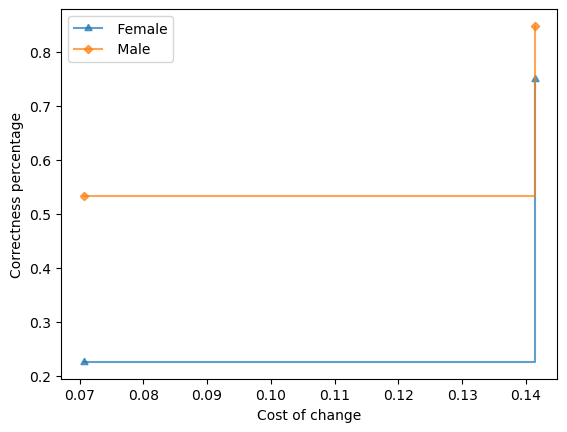

If capital-gain = (-0.001, 1593.778]:
	Protected Subgroup ' Female', 97.07% covered out of 4193
		Make capital-gain = (7070.636, 8080.727] with effectiveness 22.16% and counterfactual cost = 0.07.
		Make capital-gain = (14141.273, 15151.364] with effectiveness 73.96% and counterfactual cost = 0.14.
	Protected Subgroup ' Male', 97.13% covered out of 6552
		Make capital-gain = (7070.636, 8080.727] with effectiveness 51.26% and counterfactual cost = 0.07.
		Make capital-gain = (14141.273, 15151.364] with effectiveness 83.50% and counterfactual cost = 0.14.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 14.5.
	Cumulative effectiveness plot for the above recourses:


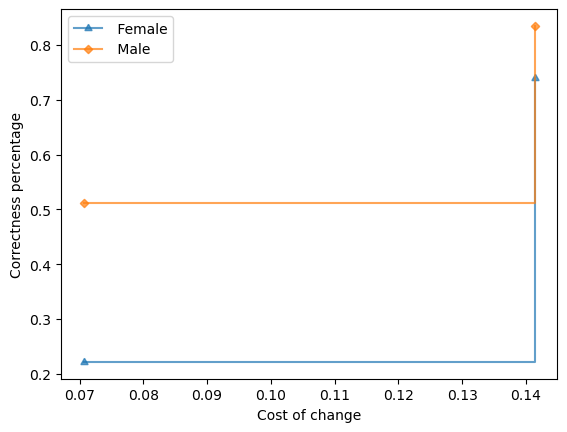

If capital-gain = (-0.001, 1593.778], native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 71.88% covered out of 4193
		Make capital-gain = (7070.636, 8080.727] with effectiveness 23.92% and counterfactual cost = 0.07.
		Make capital-gain = (14141.273, 15151.364] with effectiveness 75.65% and counterfactual cost = 0.14.
	Protected Subgroup ' Male', 77.53% covered out of 6552
		Make capital-gain = (7070.636, 8080.727] with effectiveness 55.35% and counterfactual cost = 0.07.
		Make capital-gain = (14141.273, 15151.364] with effectiveness 85.75% and counterfactual cost = 0.14.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 13.67.
	Cumulative effectiveness plot for the above recourses:


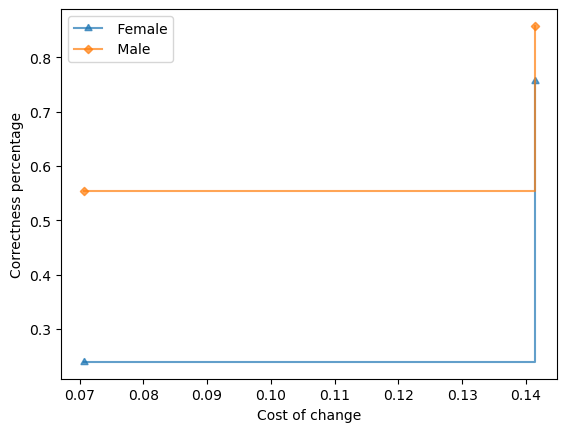

If capital-gain = (-0.001, 1593.778], race =  White:
	Protected Subgroup ' Female', 77.32% covered out of 4193
		Make capital-gain = (7070.636, 8080.727] with effectiveness 23.35% and counterfactual cost = 0.07.
		Make capital-gain = (14141.273, 15151.364] with effectiveness 74.52% and counterfactual cost = 0.14.
	Protected Subgroup ' Male', 84.13% covered out of 6552
		Make capital-gain = (7070.636, 8080.727] with effectiveness 53.21% and counterfactual cost = 0.07.
		Make capital-gain = (14141.273, 15151.364] with effectiveness 84.34% and counterfactual cost = 0.14.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 13.49.
	Cumulative effectiveness plot for the above recourses:


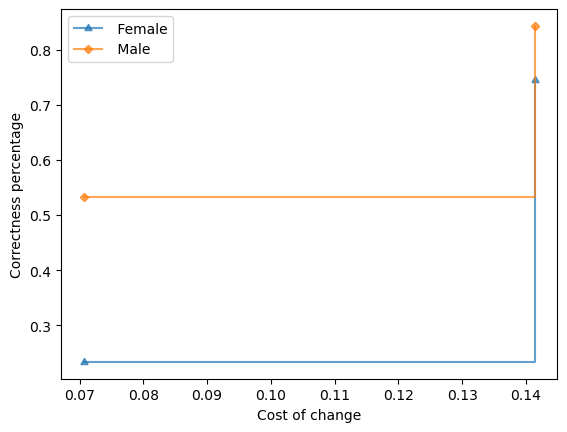

If education-num = 9:
	Protected Subgroup ' Female', 33.89% covered out of 4193
		Make education-num = 10 with effectiveness 0.56% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 5.42% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 7.60% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 10.06% and counterfactual cost = 18.0.
	Protected Subgroup ' Male', 41.58% covered out of 6552
		Make education-num = 10 with effectiveness 5.29% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 31.72% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 41.48% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 48.02% and counterfactual cost = 18.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 11.6.
	Cumulative effectiveness plot for the above recourses:


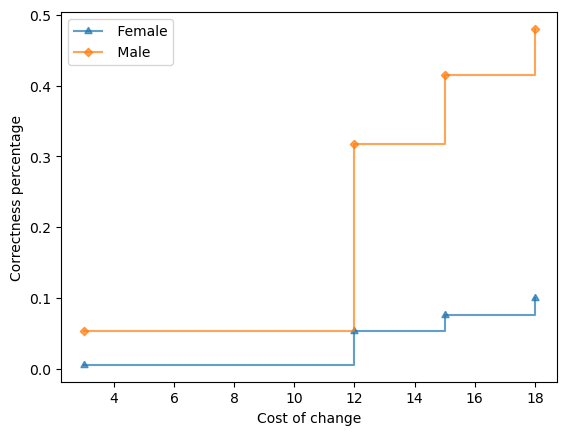

If education-num = 9, native-country =  United-States:
	Protected Subgroup ' Female', 31.31% covered out of 4193
		Make education-num = 10 with effectiveness 0.61% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 5.41% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 7.69% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 10.21% and counterfactual cost = 18.0.
	Protected Subgroup ' Male', 38.84% covered out of 6552
		Make education-num = 10 with effectiveness 5.58% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 32.89% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 42.79% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 49.27% and counterfactual cost = 18.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 11.5.
	Cumulative effectiveness plot for the above recourses:


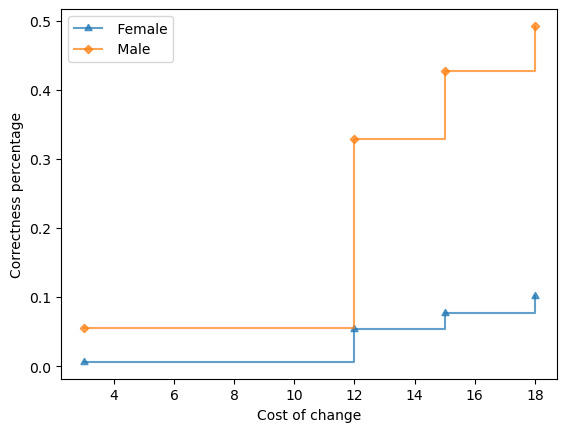

If education-num = 9, race =  White:
	Protected Subgroup ' Female', 26.90% covered out of 4193
		Make education-num = 10 with effectiveness 0.53% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 5.67% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 8.07% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 10.82% and counterfactual cost = 18.0.
	Protected Subgroup ' Male', 36.20% covered out of 6552
		Make education-num = 10 with effectiveness 5.90% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 34.02% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 43.76% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 50.25% and counterfactual cost = 18.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 10.9.
	Cumulative effectiveness plot for the above recourses:


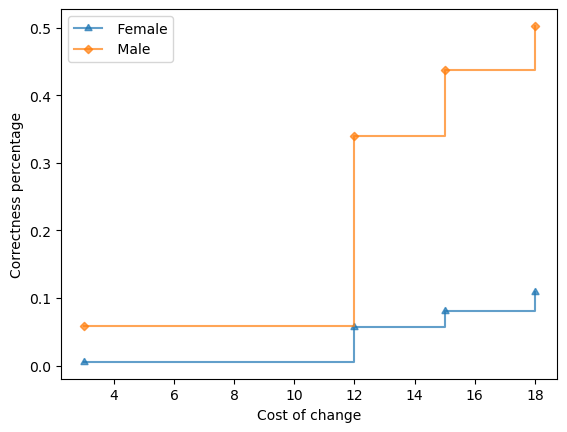

If education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 25.18% covered out of 4193
		Make education-num = 10 with effectiveness 0.57% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 5.49% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 7.95% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 10.80% and counterfactual cost = 18.0.
	Protected Subgroup ' Male', 34.45% covered out of 6552
		Make education-num = 10 with effectiveness 6.11% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 34.96% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 44.97% and counterfactual cost = 15.0.
		Make education-num = 15 with effectiveness 51.40% and counterfactual cost = 18.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 10.89.
	Cumulative effectiveness plot for the above recourses:


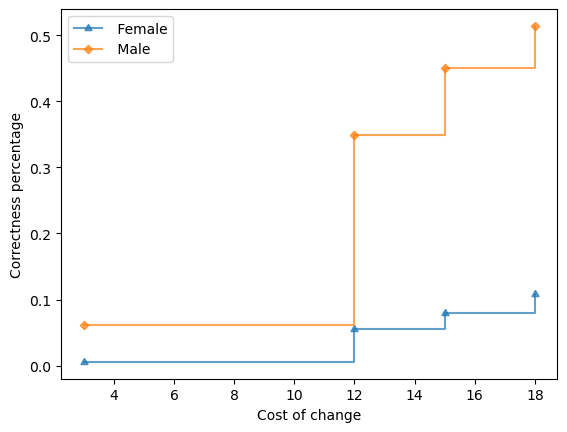

If Workclass =  Private, education-num = 9, native-country =  United-States:
	Protected Subgroup ' Female', 26.16% covered out of 4193
		Make education-num = 10 with effectiveness 0.64% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 4.56% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 7.11% and counterfactual cost = 15.0.
	Protected Subgroup ' Male', 29.73% covered out of 6552
		Make education-num = 10 with effectiveness 4.93% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 30.95% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 41.12% and counterfactual cost = 15.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 9.01.
	Cumulative effectiveness plot for the above recourses:


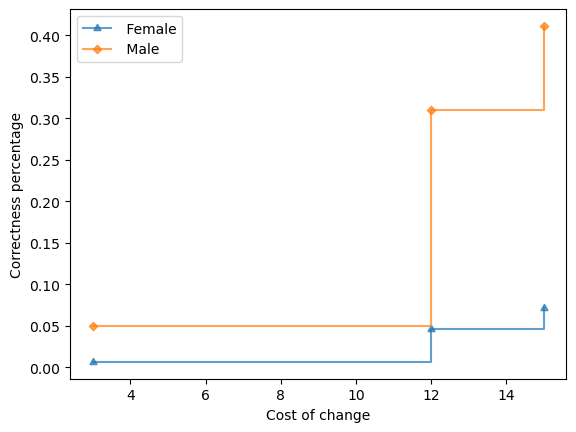

If Workclass =  Private, education-num = 9:
	Protected Subgroup ' Female', 28.33% covered out of 4193
		Make education-num = 10 with effectiveness 0.59% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 4.71% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 7.15% and counterfactual cost = 15.0.
	Protected Subgroup ' Male', 32.05% covered out of 6552
		Make education-num = 10 with effectiveness 4.62% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 29.71% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 39.67% and counterfactual cost = 15.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.96.
	Cumulative effectiveness plot for the above recourses:


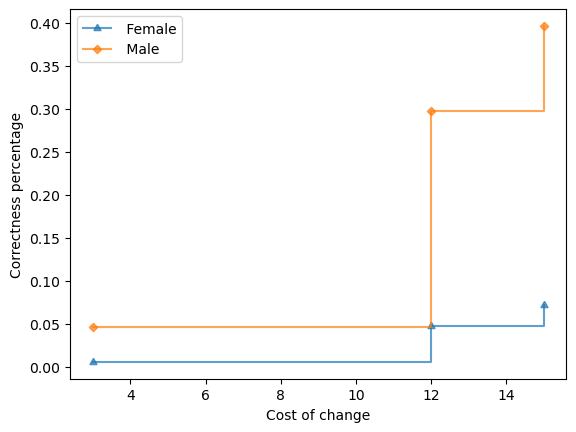

If Workclass =  Private, education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 21.25% covered out of 4193
		Make education-num = 10 with effectiveness 0.56% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 4.49% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 7.30% and counterfactual cost = 15.0.
	Protected Subgroup ' Male', 26.36% covered out of 6552
		Make education-num = 10 with effectiveness 5.39% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 33.01% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 43.25% and counterfactual cost = 15.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.72.
	Cumulative effectiveness plot for the above recourses:


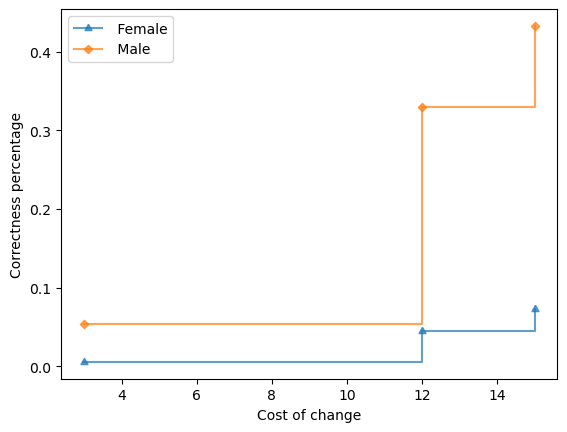

If education-num = 10:
	Protected Subgroup ' Female', 26.23% covered out of 4193
		Make education-num = 13 with effectiveness 5.36% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 6.18% and counterfactual cost = 12.0.
		Make education-num = 15 with effectiveness 7.36% and counterfactual cost = 15.0.
	Protected Subgroup ' Male', 22.48% covered out of 6552
		Make education-num = 13 with effectiveness 29.12% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 37.20% and counterfactual cost = 12.0.
		Make education-num = 15 with effectiveness 41.68% and counterfactual cost = 15.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.61.
	Cumulative effectiveness plot for the above recourses:


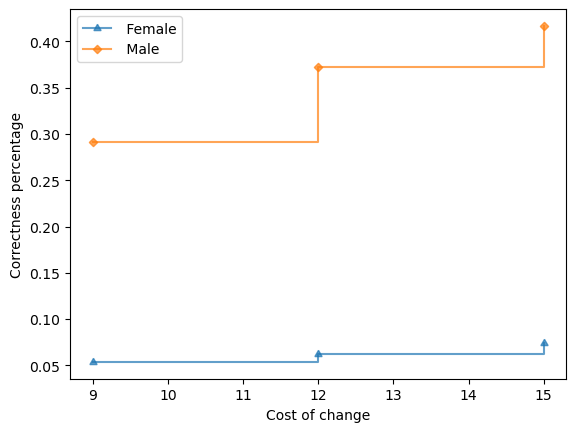

If Workclass =  Private, education-num = 9, race =  White:
	Protected Subgroup ' Female', 22.63% covered out of 4193
		Make education-num = 10 with effectiveness 0.53% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 4.85% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 7.59% and counterfactual cost = 15.0.
	Protected Subgroup ' Male', 27.82% covered out of 6552
		Make education-num = 10 with effectiveness 5.16% and counterfactual cost = 3.0.
		Make education-num = 13 with effectiveness 32.04% and counterfactual cost = 12.0.
		Make education-num = 14 with effectiveness 41.91% and counterfactual cost = 15.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.57.
	Cumulative effectiveness plot for the above recourses:


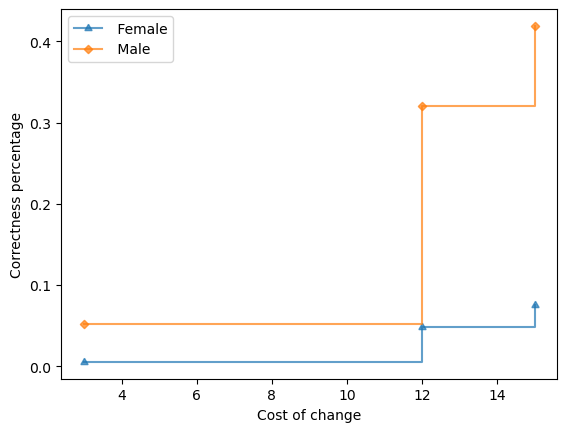

If education-num = 10, native-country =  United-States:
	Protected Subgroup ' Female', 24.42% covered out of 4193
		Make education-num = 13 with effectiveness 5.66% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 6.54% and counterfactual cost = 12.0.
		Make education-num = 15 with effectiveness 7.81% and counterfactual cost = 15.0.
	Protected Subgroup ' Male', 20.83% covered out of 6552
		Make education-num = 13 with effectiveness 29.82% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 38.02% and counterfactual cost = 12.0.
		Make education-num = 15 with effectiveness 42.27% and counterfactual cost = 15.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.33.
	Cumulative effectiveness plot for the above recourses:


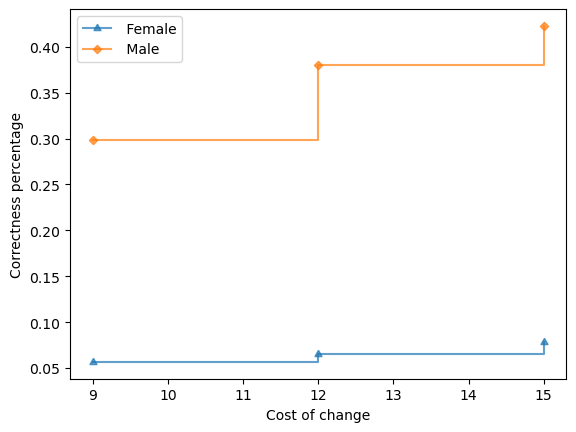

If education-num = 10, race =  White:
	Protected Subgroup ' Female', 21.11% covered out of 4193
		Make education-num = 13 with effectiveness 5.76% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 6.55% and counterfactual cost = 12.0.
		Make education-num = 15 with effectiveness 7.68% and counterfactual cost = 15.0.
	Protected Subgroup ' Male', 19.35% covered out of 6552
		Make education-num = 13 with effectiveness 30.91% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 38.80% and counterfactual cost = 12.0.
		Make education-num = 15 with effectiveness 43.53% and counterfactual cost = 15.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.18.
	Cumulative effectiveness plot for the above recourses:


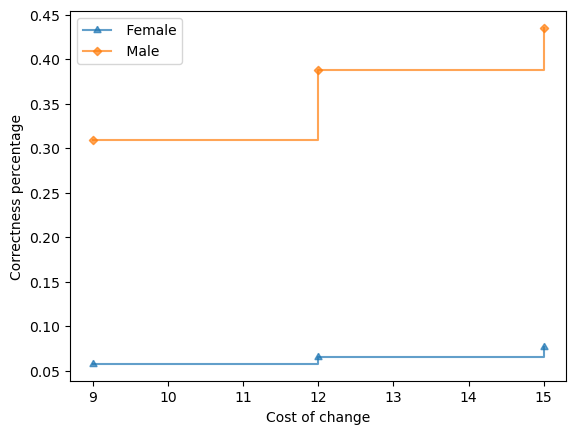

If education-num = 10, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 20.03% covered out of 4193
		Make education-num = 13 with effectiveness 5.95% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 6.79% and counterfactual cost = 12.0.
		Make education-num = 15 with effectiveness 7.98% and counterfactual cost = 15.0.
	Protected Subgroup ' Male', 18.33% covered out of 6552
		Make education-num = 13 with effectiveness 31.22% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 39.22% and counterfactual cost = 12.0.
		Make education-num = 15 with effectiveness 43.63% and counterfactual cost = 15.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.93.
	Cumulative effectiveness plot for the above recourses:


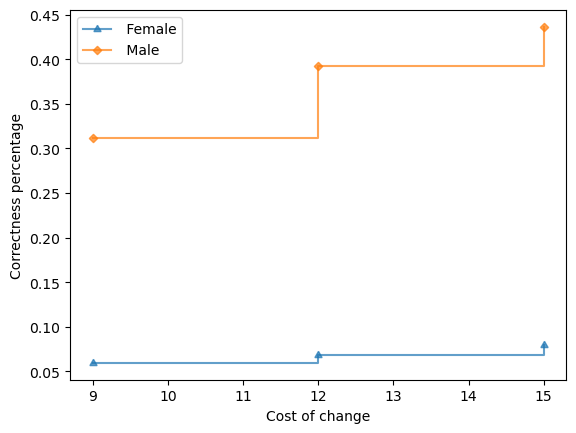

If education-num = 9, hours-per-week = (33.667, 44.556]:
	Protected Subgroup ' Female', 21.85% covered out of 4193
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 8.19% and counterfactual cost = 33.53.
	Protected Subgroup ' Male', 26.08% covered out of 6552
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 38.39% and counterfactual cost = 32.57.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.37.
	Cumulative effectiveness plot for the above recourses:


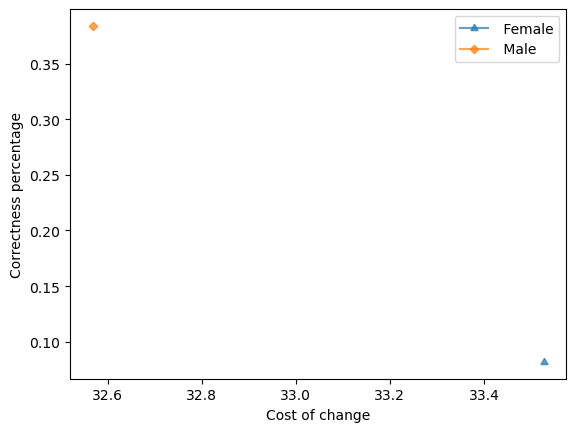

If education-num = 9, hours-per-week = (33.667, 44.556], native-country =  United-States:
	Protected Subgroup ' Female', 20.01% covered out of 4193
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 8.34% and counterfactual cost = 33.55.
	Protected Subgroup ' Male', 24.18% covered out of 6552
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 39.65% and counterfactual cost = 32.54.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.33.
	Cumulative effectiveness plot for the above recourses:


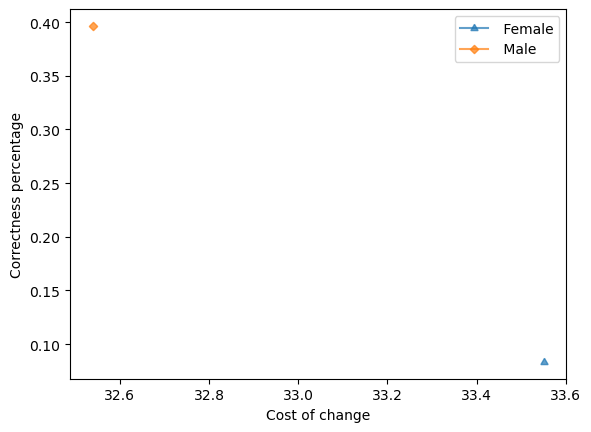

If education-num = 9, hours-per-week = (33.667, 44.556], native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 15.62% covered out of 4193
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 8.85% and counterfactual cost = 33.59.
	Protected Subgroup ' Male', 20.82% covered out of 6552
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 42.08% and counterfactual cost = 32.55.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.99.
	Cumulative effectiveness plot for the above recourses:


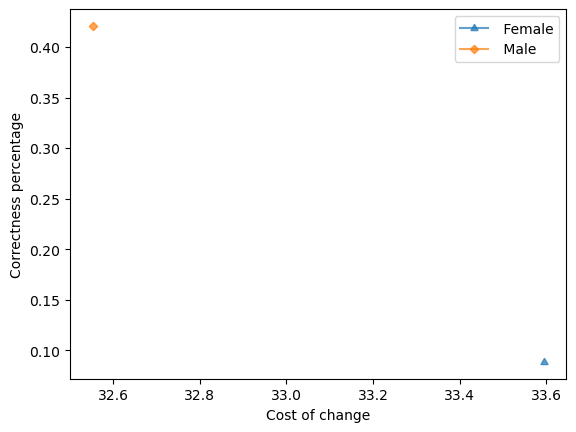

If education-num = 9, hours-per-week = (33.667, 44.556], race =  White:
	Protected Subgroup ' Female', 16.93% covered out of 4193
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 8.87% and counterfactual cost = 33.54.
	Protected Subgroup ' Male', 21.98% covered out of 6552
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 40.83% and counterfactual cost = 32.58.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.97.
	Cumulative effectiveness plot for the above recourses:


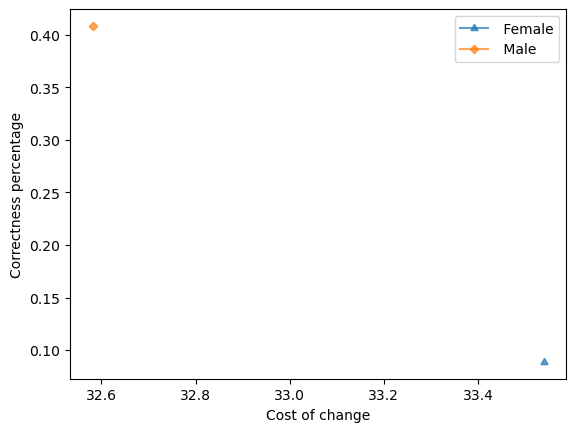

If Workclass =  Private, education-num = 10:
	Protected Subgroup ' Female', 21.20% covered out of 4193
		Make education-num = 13 with effectiveness 4.84% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 5.85% and counterfactual cost = 12.0.
	Protected Subgroup ' Male', 16.94% covered out of 6552
		Make education-num = 13 with effectiveness 28.38% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 36.13% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.73.
	Cumulative effectiveness plot for the above recourses:


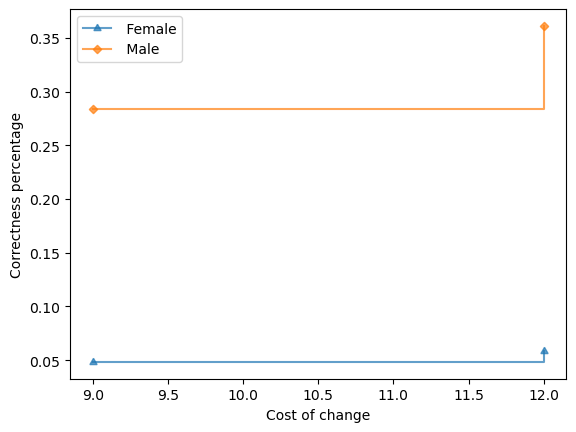

If Workclass =  Private, education-num = 10, native-country =  United-States:
	Protected Subgroup ' Female', 19.72% covered out of 4193
		Make education-num = 13 with effectiveness 5.20% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 6.29% and counterfactual cost = 12.0.
	Protected Subgroup ' Male', 15.57% covered out of 6552
		Make education-num = 13 with effectiveness 28.92% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 36.76% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.51.
	Cumulative effectiveness plot for the above recourses:


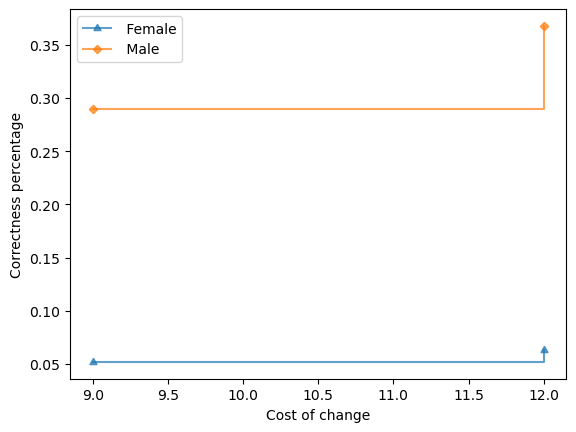

If Workclass =  Private, education-num = 10, race =  White:
	Protected Subgroup ' Female', 17.34% covered out of 4193
		Make education-num = 13 with effectiveness 5.23% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 6.19% and counterfactual cost = 12.0.
	Protected Subgroup ' Male', 14.64% covered out of 6552
		Make education-num = 13 with effectiveness 30.34% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 37.75% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.42.
	Cumulative effectiveness plot for the above recourses:


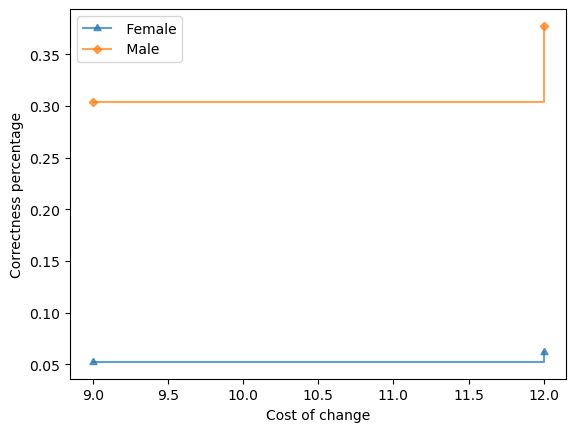

If Workclass =  Private, education-num = 10, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 16.53% covered out of 4193
		Make education-num = 13 with effectiveness 5.48% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 6.49% and counterfactual cost = 12.0.
	Protected Subgroup ' Male', 13.80% covered out of 6552
		Make education-num = 13 with effectiveness 30.53% and counterfactual cost = 9.0.
		Make education-num = 14 with effectiveness 38.05% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.25.
	Cumulative effectiveness plot for the above recourses:


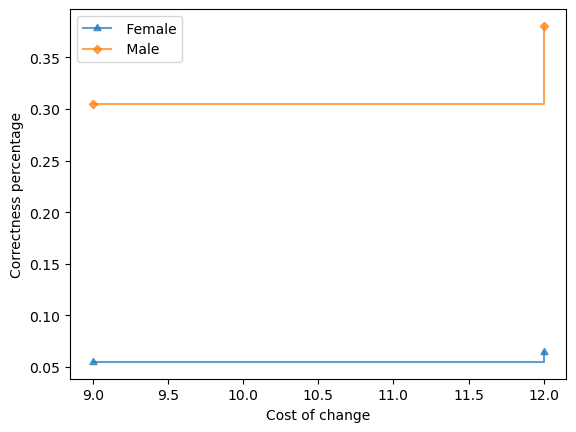

If education-num = 10, hours-per-week = (33.667, 44.556]:
	Protected Subgroup ' Female', 15.53% covered out of 4193
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 6.61% and counterfactual cost = 30.27.
	Protected Subgroup ' Male', 12.55% covered out of 6552
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 39.17% and counterfactual cost = 29.58.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.21.
	Cumulative effectiveness plot for the above recourses:


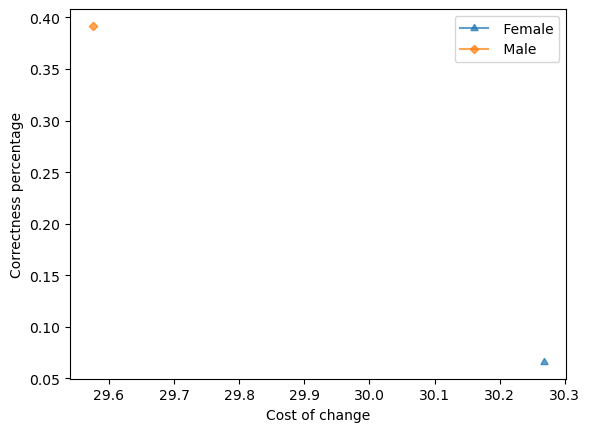

If education-num = 10, hours-per-week = (33.667, 44.556], native-country =  United-States:
	Protected Subgroup ' Female', 14.29% covered out of 4193
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 7.18% and counterfactual cost = 30.28.
	Protected Subgroup ' Male', 11.51% covered out of 6552
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 40.19% and counterfactual cost = 29.6.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.03.
	Cumulative effectiveness plot for the above recourses:


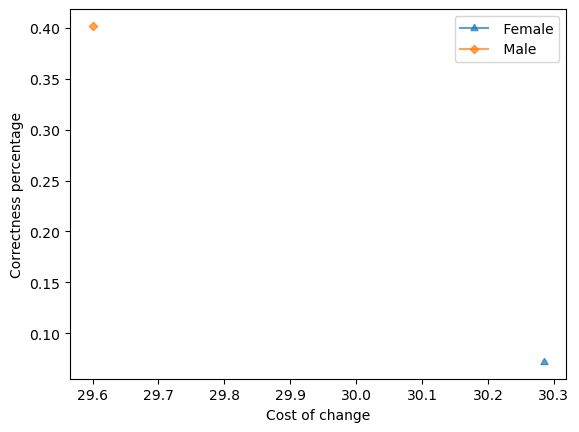

If education-num = 10, hours-per-week = (33.667, 44.556], race =  White:
	Protected Subgroup ' Female', 11.57% covered out of 4193
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 7.63% and counterfactual cost = 30.27.
	Protected Subgroup ' Male', 10.38% covered out of 6552
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 41.03% and counterfactual cost = 29.62.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 5.62.
	Cumulative effectiveness plot for the above recourses:


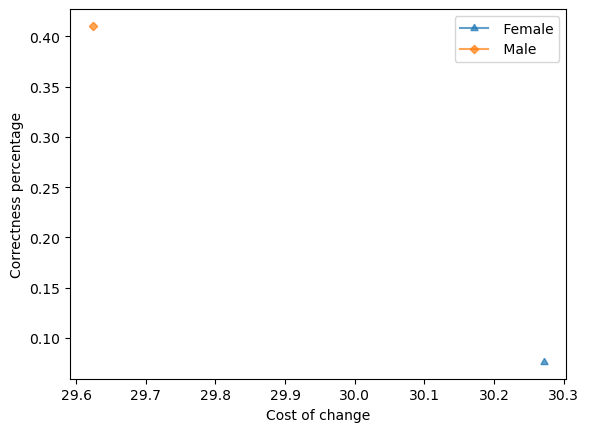

If education-num = 10, hours-per-week = (33.667, 44.556], native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 10.83% covered out of 4193
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 8.15% and counterfactual cost = 30.32.
	Protected Subgroup ' Male', 9.81% covered out of 6552
		Make education-num = 13, hours-per-week = (49.505, 50.495] with effectiveness 41.52% and counterfactual cost = 29.63.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 5.44.
	Cumulative effectiveness plot for the above recourses:


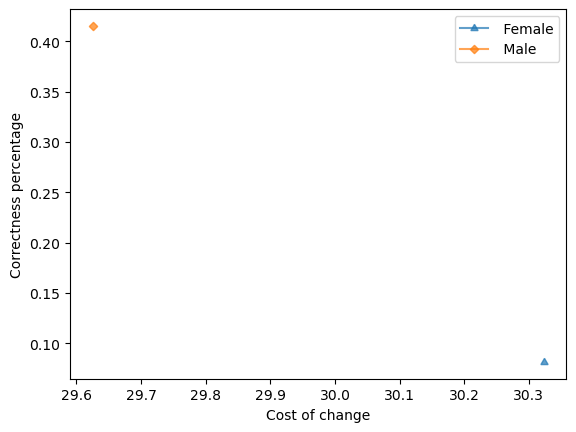

If Workclass =  Private, occupation =  Sales:
	Protected Subgroup ' Female', 12.09% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 0.99% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 1.78% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 1.97% and counterfactual cost = 6.0.
	Protected Subgroup ' Male', 8.29% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 10.50% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 22.10% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 26.89% and counterfactual cost = 6.0.
	 Unfairness based on the Fair Effectiveness-Cos

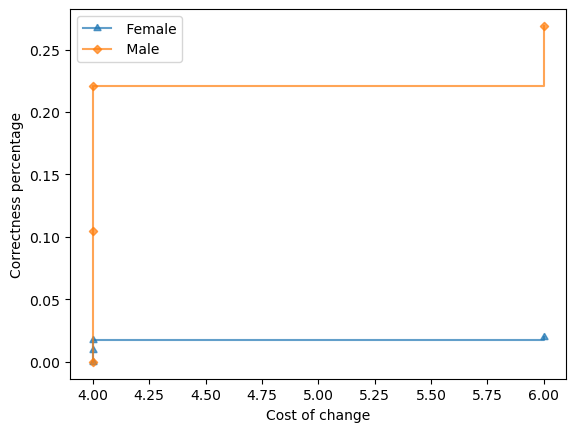

If occupation =  Sales:
	Protected Subgroup ' Female', 13.14% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 1.27% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 2.18% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 10.53% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 11.01% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 22.46% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.55.
	Cumulative effectiveness plot for the above recourses:


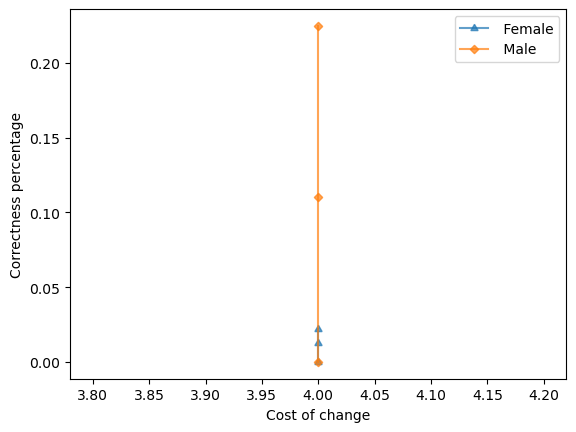

If occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 11.11% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 1.29% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 2.36% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 9.46% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 11.94% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 23.71% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.48.
	Cumulative effectiveness plot for the above recourses:


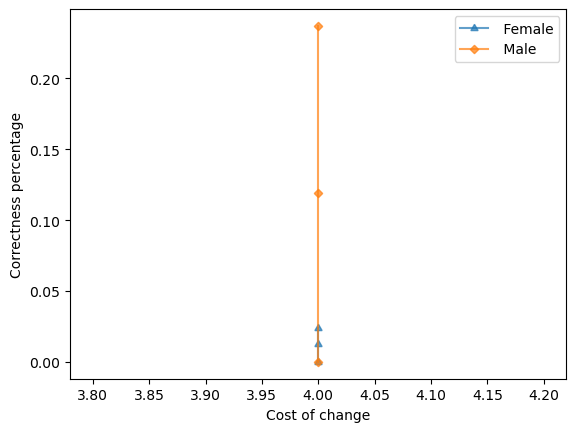

If native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Female', 12.21% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 1.37% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 2.34% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 9.86% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 10.99% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 22.76% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.45.
	Cumulative effectiveness plot for the above recourses:


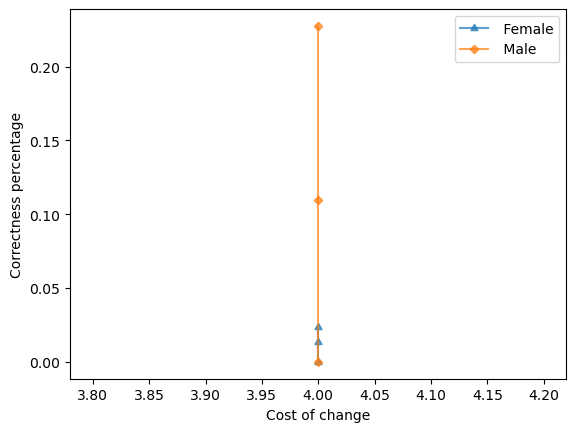

If occupation =  Adm-clerical:
	Protected Subgroup ' Female', 25.97% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 1.10% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 2.02% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 3.49% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 6.82% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 5.15% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 12.53% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 22.60% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.4.
	Cumulative effectiveness plot for the above recourses:


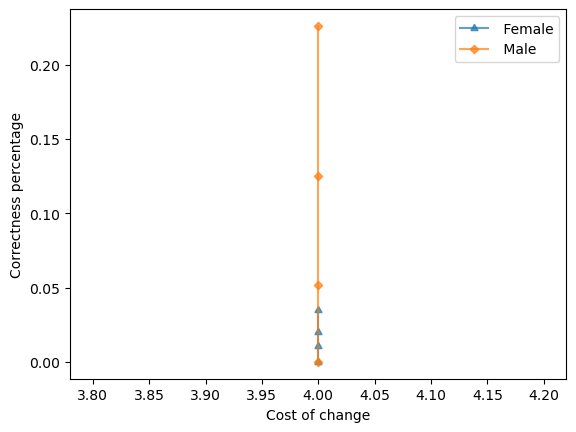

If native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 10.61% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 1.35% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 2.47% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 9.10% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 11.58% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 23.66% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.38.
	Cumulative effectiveness plot for the above recourses:


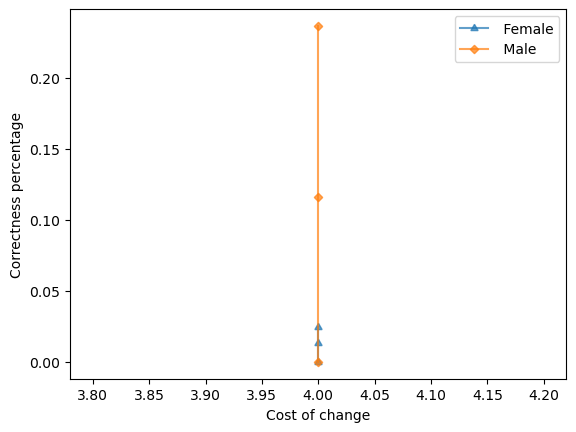

If native-country =  United-States, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 24.25% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 1.08% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 2.06% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 3.54% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 6.14% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 5.47% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 13.18% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 23.38% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.37.
	Cumulative effectiveness plot for th

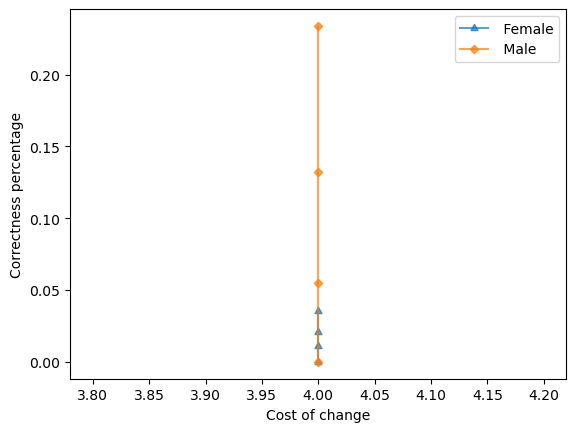

If hours-per-week = (33.667, 44.556]:
	Protected Subgroup ' Female', 61.15% covered out of 4193
		Make hours-per-week = (44.556, 45.545] with effectiveness 0.74% and counterfactual cost = 11.48.
		Make hours-per-week = (49.505, 50.495] with effectiveness 1.29% and counterfactual cost = 21.38.
		Make hours-per-week = (59.404, 60.394] with effectiveness 2.61% and counterfactual cost = 41.18.
	Protected Subgroup ' Male', 59.74% covered out of 6552
		Make hours-per-week = (44.556, 45.545] with effectiveness 2.89% and counterfactual cost = 10.73.
		Make hours-per-week = (49.505, 50.495] with effectiveness 5.93% and counterfactual cost = 20.63.
		Make hours-per-week = (59.404, 60.394] with effectiveness 10.96% and counterfactual cost = 40.42.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.29.
	Cumulative effectiveness plot for the above recourses:


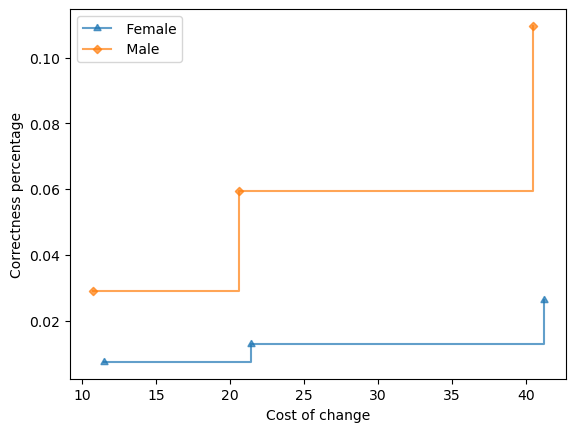

If Workclass =  Private, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 10.18% covered out of 4193
		Make occupation =  Prof-specialty with effectiveness 0.94% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 1.87% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 7.36% covered out of 6552
		Make occupation =  Prof-specialty with effectiveness 11.41% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 23.44% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.25.
	Cumulative effectiveness plot for the above recourses:


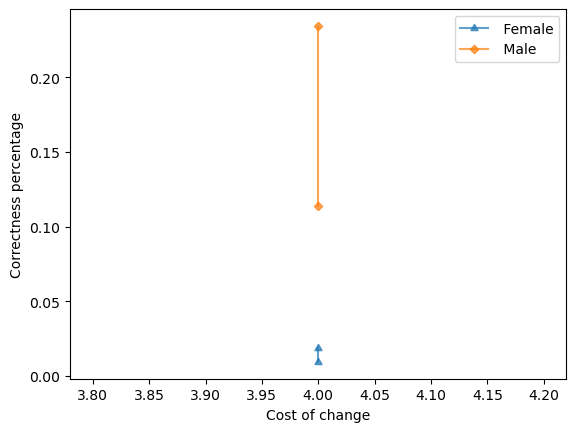

If occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Female', 20.58% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 1.04% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 1.74% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 3.48% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 5.65% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 5.41% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 12.70% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 23.51% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.22.
	Cumulative effectiveness plot for the above recourses:

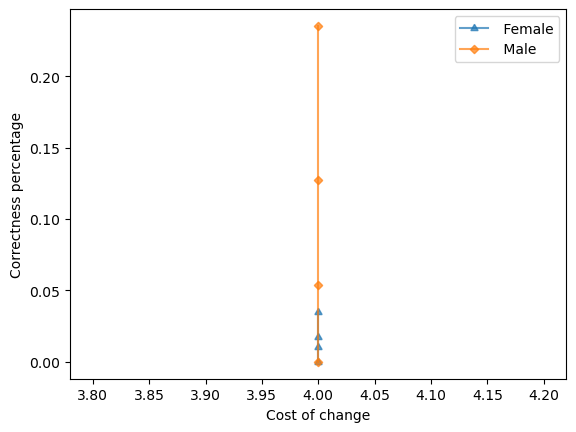

If hours-per-week = (33.667, 44.556], native-country =  United-States:
	Protected Subgroup ' Female', 55.07% covered out of 4193
		Make hours-per-week = (44.556, 45.545] with effectiveness 0.82% and counterfactual cost = 11.48.
		Make hours-per-week = (49.505, 50.495] with effectiveness 1.39% and counterfactual cost = 21.38.
		Make hours-per-week = (59.404, 60.394] with effectiveness 2.82% and counterfactual cost = 41.18.
	Protected Subgroup ' Male', 52.85% covered out of 6552
		Make hours-per-week = (44.556, 45.545] with effectiveness 3.03% and counterfactual cost = 10.68.
		Make hours-per-week = (49.505, 50.495] with effectiveness 6.21% and counterfactual cost = 20.58.
		Make hours-per-week = (59.404, 60.394] with effectiveness 11.44% and counterfactual cost = 40.38.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.21.
	Cumulative effectiveness plot for the above recourses:


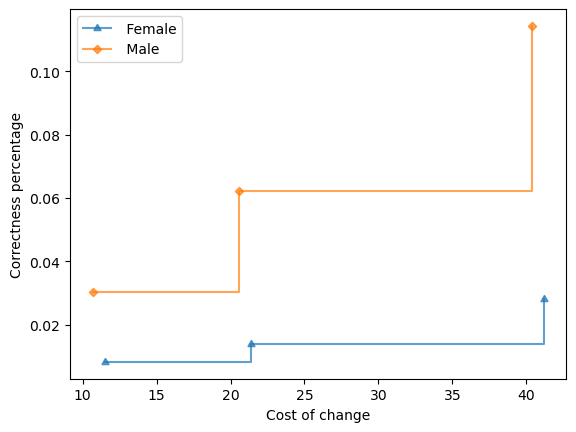

If Workclass =  Private, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Female', 11.28% covered out of 4193
		Make occupation =  Prof-specialty with effectiveness 1.06% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 1.90% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 7.78% covered out of 6552
		Make occupation =  Prof-specialty with effectiveness 10.59% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 22.35% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.2.
	Cumulative effectiveness plot for the above recourses:


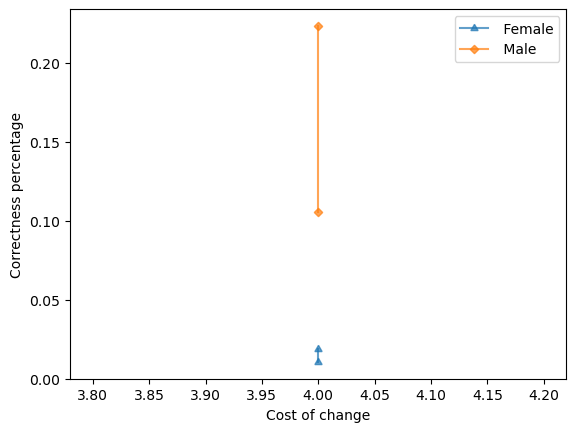

If native-country =  United-States, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Female', 19.60% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 1.09% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 1.82% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 3.53% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 5.20% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 5.87% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 13.20% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 24.05% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.19.
	Cumulative effectiven

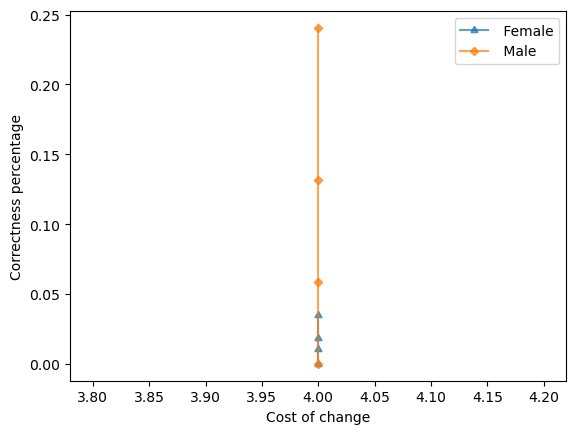

If Workclass =  Private, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 9.75% covered out of 4193
		Make occupation =  Prof-specialty with effectiveness 0.98% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 1.96% and counterfactual cost = 4.0.
	Protected Subgroup ' Male', 7.13% covered out of 6552
		Make occupation =  Prof-specialty with effectiveness 11.13% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 23.34% and counterfactual cost = 4.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.16.
	Cumulative effectiveness plot for the above recourses:


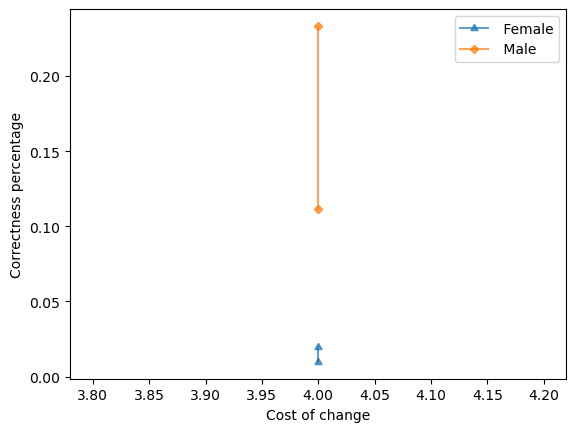

If hours-per-week = (33.667, 44.556], race =  White:
	Protected Subgroup ' Female', 46.77% covered out of 4193
		Make hours-per-week = (44.556, 45.545] with effectiveness 0.76% and counterfactual cost = 11.47.
		Make hours-per-week = (49.505, 50.495] with effectiveness 1.27% and counterfactual cost = 21.37.
		Make hours-per-week = (59.404, 60.394] with effectiveness 2.60% and counterfactual cost = 41.17.
	Protected Subgroup ' Male', 50.14% covered out of 6552
		Make hours-per-week = (44.556, 45.545] with effectiveness 3.14% and counterfactual cost = 10.74.
		Make hours-per-week = (49.505, 50.495] with effectiveness 6.45% and counterfactual cost = 20.63.
		Make hours-per-week = (59.404, 60.394] with effectiveness 11.54% and counterfactual cost = 40.43.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.13.
	Cumulative effectiveness plot for the above recourses:


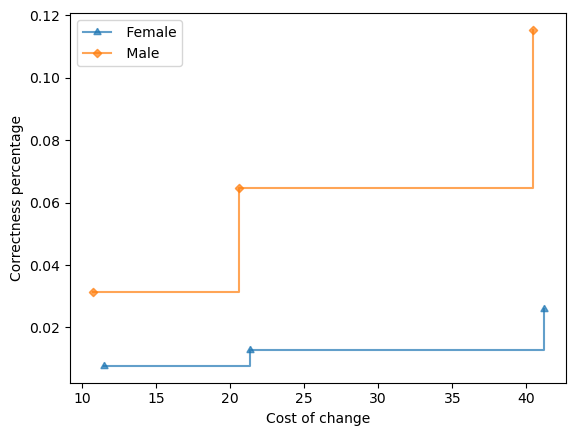

If capital-gain = (-0.001, 1593.778], race =  Black:
	Protected Subgroup ' Female', 14.76% covered out of 4193
		Make capital-gain = (7070.636, 8080.727], race =  White with effectiveness 17.29% and counterfactual cost = 100.07.
		Make capital-gain = (14141.273, 15151.364], race =  White with effectiveness 74.47% and counterfactual cost = 100.14.
	Protected Subgroup ' Male', 8.49% covered out of 6552
		Make capital-gain = (7070.636, 8080.727], race =  White with effectiveness 35.43% and counterfactual cost = 100.07.
		Make capital-gain = (14141.273, 15151.364], race =  White with effectiveness 78.24% and counterfactual cost = 100.14.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.11.
	Cumulative effectiveness plot for the above recourses:


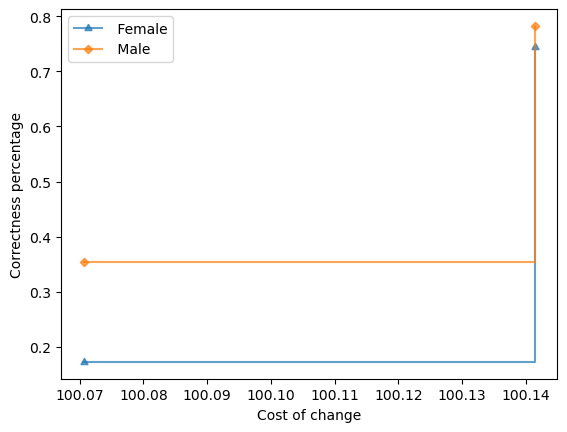

If hours-per-week = (33.667, 44.556], native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 43.00% covered out of 4193
		Make hours-per-week = (44.556, 45.545] with effectiveness 0.83% and counterfactual cost = 11.49.
		Make hours-per-week = (49.505, 50.495] with effectiveness 1.39% and counterfactual cost = 21.39.
		Make hours-per-week = (59.404, 60.394] with effectiveness 2.77% and counterfactual cost = 41.19.
	Protected Subgroup ' Male', 45.53% covered out of 6552
		Make hours-per-week = (44.556, 45.545] with effectiveness 3.29% and counterfactual cost = 10.7.
		Make hours-per-week = (49.505, 50.495] with effectiveness 6.70% and counterfactual cost = 20.6.
		Make hours-per-week = (59.404, 60.394] with effectiveness 12.00% and counterfactual cost = 40.39.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.09.
	Cumulative effectiveness plot for the above recourses:


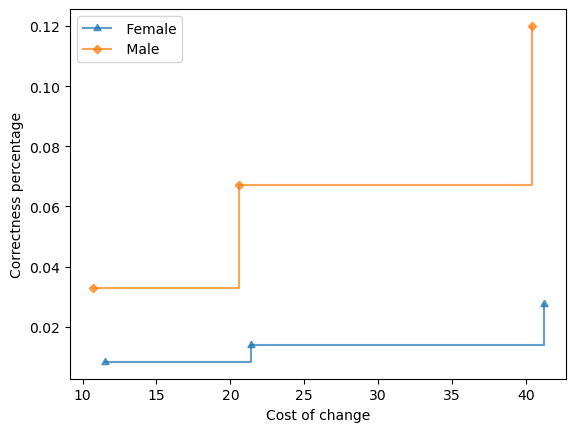

If capital-gain = (-0.001, 1593.778], native-country =  United-States, race =  Black:
	Protected Subgroup ' Female', 13.93% covered out of 4193
		Make capital-gain = (7070.636, 8080.727], race =  White with effectiveness 17.29% and counterfactual cost = 100.07.
		Make capital-gain = (14141.273, 15151.364], race =  White with effectiveness 75.00% and counterfactual cost = 100.14.
	Protected Subgroup ' Male', 8.01% covered out of 6552
		Make capital-gain = (7070.636, 8080.727], race =  White with effectiveness 35.62% and counterfactual cost = 100.07.
		Make capital-gain = (14141.273, 15151.364], race =  White with effectiveness 77.90% and counterfactual cost = 100.14.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 3.05.
	Cumulative effectiveness plot for the above recourses:


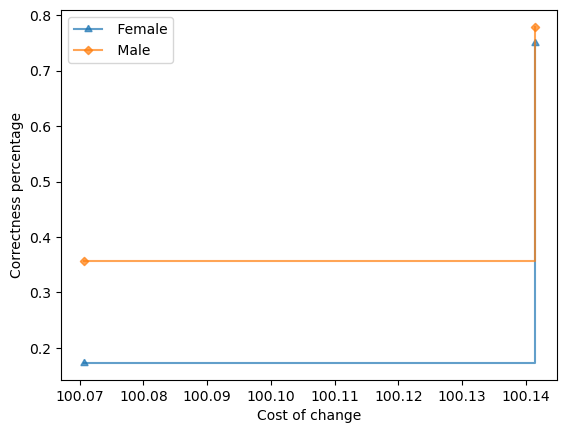

If Workclass =  Private, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 5.77% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 0.41% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 0.41% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 0.83% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 1.65% and counterfactual cost = 6.0.
	Protected Subgroup ' Male', 8.73% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 3.85% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 6.82% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 10.31% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 19.58% and counterfactual cost

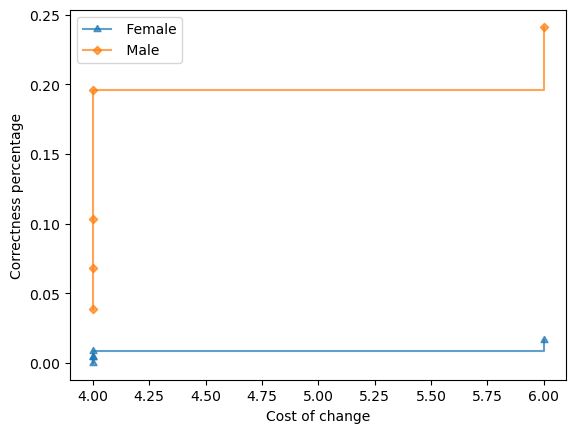

If Workclass =  Private:
	Protected Subgroup ' Female', 79.11% covered out of 4193
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 0.42% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 1.48% and counterfactual cost = 2.0.
	Protected Subgroup ' Male', 76.16% covered out of 6552
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 2.48% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 7.78% and counterfactual cost = 2.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.81.
	Cumulative effectiveness plot for the above recourses:


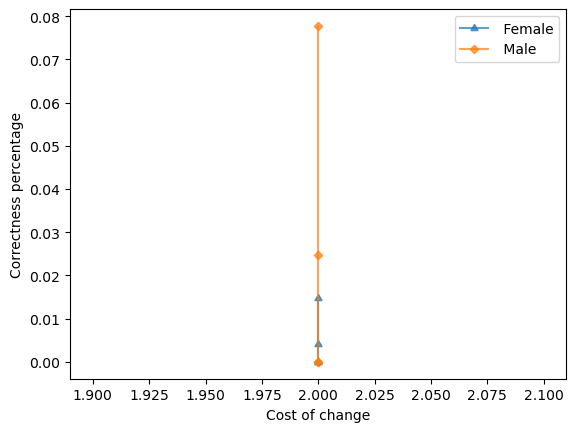

If Workclass =  Private, hours-per-week = (33.667, 44.556]:
	Protected Subgroup ' Female', 48.41% covered out of 4193
		Make hours-per-week = (44.556, 45.545] with effectiveness 0.64% and counterfactual cost = 11.52.
		Make hours-per-week = (49.505, 50.495] with effectiveness 1.28% and counterfactual cost = 21.42.
		Make hours-per-week = (59.404, 60.394] with effectiveness 2.46% and counterfactual cost = 41.22.
	Protected Subgroup ' Male', 47.56% covered out of 6552
		Make hours-per-week = (44.556, 45.545] with effectiveness 2.66% and counterfactual cost = 10.67.
		Make hours-per-week = (49.505, 50.495] with effectiveness 5.26% and counterfactual cost = 20.57.
		Make hours-per-week = (59.404, 60.394] with effectiveness 9.69% and counterfactual cost = 40.37.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.53.
	Cumulative effectiveness plot for the above recourses:


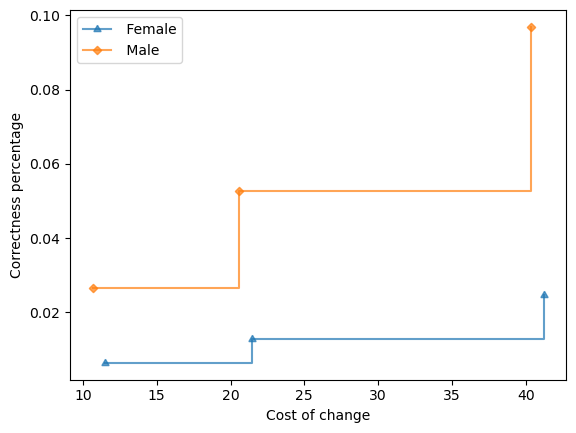

If Workclass =  Private, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 20.46% covered out of 4193
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 1.05% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 1.98% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 3.38% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 4.66% and counterfactual cost = 6.0.
	Protected Subgroup ' Male', 5.25% covered out of 6552
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 3.49% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 8.43% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 18.02% and counterfactual cost = 4.

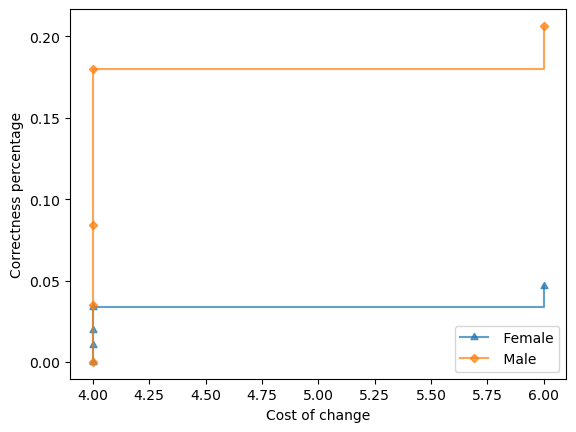

In [27]:
affected_pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)